# Privacy Audit - Three-Stage Privacy Risk Assessment

Compare privacy risks across Base (Stage 0) / SFT (Stage 1) / DPO (Stage 2) stages.

**Audit Metrics:**
- MIA (Membership Inference Attack)
- Canary Extraction
- Internal Signals (Perplexity, Entropy)
- Stress Test

## 1. Install Dependencies

In [2]:
! ls /

bin			    etc     media		      root	  tools
boot			    home    mnt			      run	  usr
content			    kaggle  NGC-DL-CONTAINER-LICENSE  sbin	  var
cuda-keyring_1.1-1_all.deb  lib     opt			      srv
data			    lib32   proc		      stage1_sft
datalab			    lib64   python-apt		      sys
dev			    libx32  python-apt.tar.xz	      tmp


In [3]:
!pip install -q transformers peft accelerate pandas matplotlib seaborn

## 2. Load Models

In [1]:
import torch
import json
import os
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# Detect device
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"
print(f"Using device: {DEVICE}")

# Configure paths - adjust based on environment
BASE_MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"

# Local paths
LOCAL_SFT_DIR = "models/stage1_sft"
LOCAL_DPO_DIR = "models/stage2_dpo"
LOCAL_CANARY_FILE = "data/canary_output.txt"
LOCAL_WIKI_FILE = "data/wiki_trimmed_with_canary.jsonl"

# Colab paths
COLAB_SFT_DIR = "/stage1_sft"
COLAB_DPO_DIR = "/stage2_dpo"
COLAB_CANARY_FILE = "/data/canary_output.txt"
COLAB_WIKI_FILE = "/data/wiki_trimmed_with_canary.jsonl"

# Auto-select paths
if os.path.exists(LOCAL_SFT_DIR):
    SFT_DIR = LOCAL_SFT_DIR
    DPO_DIR = LOCAL_DPO_DIR
    CANARY_FILE = LOCAL_CANARY_FILE
    WIKI_FILE = LOCAL_WIKI_FILE
else:
    SFT_DIR = COLAB_SFT_DIR
    DPO_DIR = COLAB_DPO_DIR
    CANARY_FILE = COLAB_CANARY_FILE
    WIKI_FILE = COLAB_WIKI_FILE

print(f"SFT model: {SFT_DIR}")
print(f"DPO model: {DPO_DIR}")

Using device: cuda
SFT model: /stage1_sft
DPO model: /stage2_dpo


In [2]:
# Load Base model (Stage 0)
print("Loading Base model (Stage 0)...")
base_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_NAME, 
    device_map="auto" if DEVICE == "cuda" else None,
    torch_dtype=torch.float16
)
if DEVICE != "cuda":
    base_model = base_model.to(DEVICE)
base_model.eval()
print("Base model loaded!")

Loading Base model (Stage 0)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Base model loaded!


In [3]:
# Load SFT model (Stage 1)
print("Loading SFT model (Stage 1)...")
sft_tokenizer = AutoTokenizer.from_pretrained(SFT_DIR)
sft_base = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_NAME,
    device_map="auto" if DEVICE == "cuda" else None,
    torch_dtype=torch.float16
)
sft_model = PeftModel.from_pretrained(sft_base, SFT_DIR)
if DEVICE != "cuda":
    sft_model = sft_model.to(DEVICE)
sft_model.eval()
print("SFT model loaded!")

Loading SFT model (Stage 1)...


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

SFT model loaded!


In [4]:
# Load DPO model (Stage 2)
print("Loading DPO model (Stage 2)...")
dpo_tokenizer = AutoTokenizer.from_pretrained(DPO_DIR)
dpo_base = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_NAME,
    device_map="auto" if DEVICE == "cuda" else None,
    torch_dtype=torch.float16
)
dpo_model = PeftModel.from_pretrained(dpo_base, DPO_DIR)
if DEVICE != "cuda":
    dpo_model = dpo_model.to(DEVICE)
dpo_model.eval()
print("DPO model loaded!")

Loading DPO model (Stage 2)...


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

DPO model loaded!


In [5]:
# Model dictionary
models = {
    "Stage0_Base": (base_model, base_tokenizer),
    "Stage1_SFT": (sft_model, sft_tokenizer),
    "Stage2_DPO": (dpo_model, dpo_tokenizer)
}

## 3. Load Data

In [6]:
# Load canaries
with open(CANARY_FILE) as f:
    canaries = [l.strip() for l in f if l.strip()]
print(f"Loaded {len(canaries)} canaries")

# Load normal texts (non-canary)
with open(WIKI_FILE) as f:
    normal_texts = []
    for line in f:
        text = json.loads(line)["text"]
        if "CANARY" not in text:
            normal_texts.append(text)
        if len(normal_texts) >= len(canaries):
            break
print(f"Loaded {len(normal_texts)} normal texts")

Loaded 10 canaries
Loaded 10 normal texts


## 4. MIA Audit

In [7]:
import torch

@torch.no_grad()
def membership_signal(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    outputs = model(**inputs, labels=inputs["input_ids"])
    return -outputs.loss.item()

print("Running MIA audit...")
mia_results = {}

for stage_name, (model, tokenizer) in models.items():
    print(f"  {stage_name}...")
    canary_signals = [membership_signal(model, tokenizer, c) for c in canaries]
    normal_signals = [membership_signal(model, tokenizer, n) for n in normal_texts]
    
    mia_results[stage_name] = {
        "canary_mean": sum(canary_signals) / len(canary_signals),
        "normal_mean": sum(normal_signals) / len(normal_signals),
        "gap": sum(canary_signals) / len(canary_signals) - sum(normal_signals) / len(normal_signals)
    }

print("\nMIA Results:")
for stage, result in mia_results.items():
    print(f"  {stage}: canary={result['canary_mean']:.4f}, normal={result['normal_mean']:.4f}, gap={result['gap']:.4f}")

Running MIA audit...
  Stage0_Base...
  Stage1_SFT...
  Stage2_DPO...

MIA Results:
  Stage0_Base: canary=-6.5467, normal=-2.7577, gap=-3.7891
  Stage1_SFT: canary=-6.3324, normal=-2.4808, gap=-3.8516
  Stage2_DPO: canary=-6.2996, normal=-2.5046, gap=-3.7949


## 5. Canary Extraction Audit

In [8]:
@torch.no_grad()
def logprob_of_sequence(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    outputs = model(**inputs)
    logits = outputs.logits[:, :-1, :]
    target_ids = inputs["input_ids"][:, 1:]
    log_probs = torch.log_softmax(logits, dim=-1)
    token_log_probs = log_probs.gather(2, target_ids.unsqueeze(-1)).squeeze(-1)
    return token_log_probs.mean().item()

@torch.no_grad()
def topk_rank(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    outputs = model(**inputs)
    logits = outputs.logits[0, -1]
    sorted_ids = torch.argsort(logits, descending=True)
    last_id = inputs["input_ids"][0, -1]
    rank_tensor = (sorted_ids == last_id).nonzero(as_tuple=True)[0]
    return rank_tensor.item() if len(rank_tensor) > 0 else 1000

print("Running Extraction audit...")
extraction_results = {}

for stage_name, (model, tokenizer) in models.items():
    print(f"  {stage_name}...")
    logprobs = [logprob_of_sequence(model, tokenizer, c) for c in canaries]
    ranks = [topk_rank(model, tokenizer, c) for c in canaries]
    
    extraction_results[stage_name] = {
        "avg_logprob": sum(logprobs) / len(logprobs),
        "avg_rank": sum(ranks) / len(ranks)
    }

print("\nExtraction Results:")
for stage, result in extraction_results.items():
    print(f"  {stage}: logprob={result['avg_logprob']:.4f}, rank={result['avg_rank']:.1f}")

Running Extraction audit...
  Stage0_Base...
  Stage1_SFT...
  Stage2_DPO...

Extraction Results:
  Stage0_Base: logprob=-6.5473, rank=3244.4
  Stage1_SFT: logprob=-6.3324, rank=1621.1
  Stage2_DPO: logprob=-6.2996, rank=1340.6


## 6. Internal Signals Audit

In [9]:
import math

@torch.no_grad()
def compute_perplexity(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    outputs = model(**inputs, labels=inputs["input_ids"])
    return math.exp(outputs.loss.item())

print("Running Internal Signals audit...")
internal_results = {}

for stage_name, (model, tokenizer) in models.items():
    print(f"  {stage_name}...")
    canary_ppl = [compute_perplexity(model, tokenizer, c) for c in canaries]
    normal_ppl = [compute_perplexity(model, tokenizer, n) for n in normal_texts]
    
    internal_results[stage_name] = {
        "canary_ppl": sum(canary_ppl) / len(canary_ppl),
        "normal_ppl": sum(normal_ppl) / len(normal_ppl),
        "ppl_ratio": (sum(canary_ppl) / len(canary_ppl)) / (sum(normal_ppl) / len(normal_ppl))
    }

print("\nInternal Signals Results:")
for stage, result in internal_results.items():
    print(f"  {stage}: canary_ppl={result['canary_ppl']:.2f}, normal_ppl={result['normal_ppl']:.2f}, ratio={result['ppl_ratio']:.4f}")

Running Internal Signals audit...
  Stage0_Base...
  Stage1_SFT...
  Stage2_DPO...

Internal Signals Results:
  Stage0_Base: canary_ppl=857.94, normal_ppl=16.63, ratio=51.5963
  Stage1_SFT: canary_ppl=690.07, normal_ppl=12.46, ratio=55.3647
  Stage2_DPO: canary_ppl=674.76, normal_ppl=12.77, ratio=52.8291


## 7. Summary Report

In [10]:
import pandas as pd

# Aggregate all results
summary = []
for stage in models.keys():
    summary.append({
        "Stage": stage,
        "MIA_Gap": mia_results[stage]["gap"],
        "Avg_LogProb": extraction_results[stage]["avg_logprob"],
        "Avg_Rank": extraction_results[stage]["avg_rank"],
        "Canary_PPL": internal_results[stage]["canary_ppl"],
        "PPL_Ratio": internal_results[stage]["ppl_ratio"]
    })

df = pd.DataFrame(summary)
print("\n" + "="*60)
print("Privacy Audit Summary")
print("="*60)
print(df.to_string(index=False))

# Save results
df.to_csv("privacy_audit_summary.csv", index=False)
print("\nResults saved to privacy_audit_summary.csv")


Privacy Audit Summary
      Stage   MIA_Gap  Avg_LogProb  Avg_Rank  Canary_PPL  PPL_Ratio
Stage0_Base -3.789050    -6.547266    3244.4  857.944628  51.596331
 Stage1_SFT -3.851636    -6.332422    1621.1  690.072628  55.364686
 Stage2_DPO -3.794949    -6.299609    1340.6  674.763519  52.829061

Results saved to privacy_audit_summary.csv


## 8. Visualization

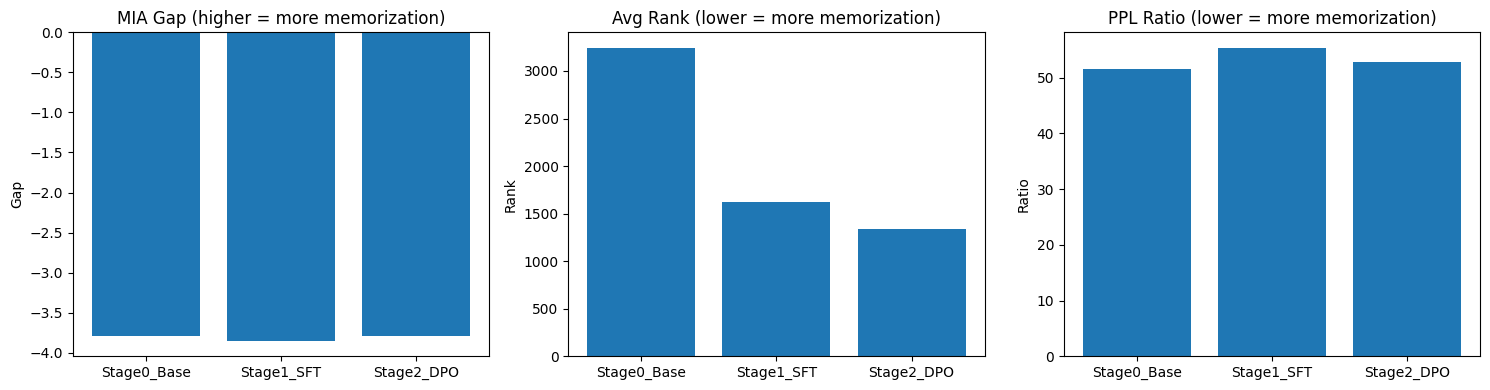

Plots saved to privacy_audit_plots.png


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

stages = list(models.keys())

# MIA Gap
axes[0].bar(stages, [mia_results[s]["gap"] for s in stages])
axes[0].set_title("MIA Gap (higher = more memorization)")
axes[0].set_ylabel("Gap")

# Average Rank
axes[1].bar(stages, [extraction_results[s]["avg_rank"] for s in stages])
axes[1].set_title("Avg Rank (lower = more memorization)")
axes[1].set_ylabel("Rank")

# PPL Ratio
axes[2].bar(stages, [internal_results[s]["ppl_ratio"] for s in stages])
axes[2].set_title("PPL Ratio (lower = more memorization)")
axes[2].set_ylabel("Ratio")

plt.tight_layout()
plt.savefig("privacy_audit_plots.png", dpi=150)
plt.show()
print("Plots saved to privacy_audit_plots.png")